# PLAN ANALIZY DANYCH – WESAD (CHEST + WRIST)

## Cel projektu
Klasyfikacja stanów: **baseline, stress, amusement** przy silnym niezbalansowaniu klas.

## Hipoteza badawcza
W warunkach stresu (w porównaniu do baseline i amusement) obserwujemy:
- **Wzrost**: przewodnictwo skóry (EDA), tętno (HR), tempo oddychania
- **Spadek**: zmienność rytmu serca (HRV/RMSSD)
- **Korelacje**: sygnały z nadgarstka (Empatica E4) i klatki piersiowej (RespiBAN) są silnie skorelowane

---

## Struktura analizy
1. Import danych i ich zrozumienie
2. Wstępna obróbka (preprocessing)
3. Segmentacja sygnałów
4. Problem niezbalansowanych klas
5. Jak obejść niezbalansowanie – prawidłowa procedura
6. Tworzenie cech (feature engineering)
7. Podział danych i ewaluacja
8. Trenowanie modeli
9. Analiza wyników
10. Interpretacja i raport


## 1. Import danych i ich zrozumienie

### 1.1. Pobranie i wczytanie plików

**Cel:** Zrozumieć strukturę danych – różne częstotliwości próbkowania!

- Wczytujemy dane z folderów `WESAD/SX/` dla każdego uczestnika (np. S2, S3, S4…)
- Wczytujemy dane z czujników:
  - **Chest** (ECG, EDA, EMG, Temp, Resp, ACC) - 700 Hz
  - **Wrist** (BVP, EDA, Temp, ACC) - 32 Hz

**Kluczowe:** Różne częstotliwości próbkowania wymagają synchronizacji!


In [14]:
# ============================================================================
# IMPORT I KONFIGURACJA
# ============================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Ścieżki
PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")

# Parametry
TARGET_FS = 32.0  # Docelowa częstotliwość próbkowania
CHEST_FS = 700.0  # Częstotliwość próbkowania czujnika klatki piersiowej

# Uczestnicy do analizy
SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

# Mapowanie faz do klas
PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
}

print("✓ Konfiguracja załadowana")
print(f"✓ Uczestnicy: {', '.join(SUBJECTS)}")
print(f"✓ Docelowa częstotliwość próbkowania: {TARGET_FS} Hz")


✓ Konfiguracja załadowana
✓ Uczestnicy: S2, S3, S4, S5, S6, S7
✓ Docelowa częstotliwość próbkowania: 32.0 Hz


In [15]:
# ============================================================================
# SEKCJA 1: WCZYTYWANIE I ANALIZA DANYCH
# ============================================================================

print("=" * 80)
print("SEKCJA 1: IMPORT DANYCH I ICH ZROZUMIENIE")
print("=" * 80)

# Sprawdzamy, czy mamy już przetworzone dane
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed" / "multi_subject_wrist_chest.csv"

if PROCESSED_DATA_PATH.exists():
    print(f"\n✓ Znaleziono przetworzone dane: {PROCESSED_DATA_PATH}")
    print(f"  → Używamy gotowych danych z wcześniejszej analizy")
    print(f"  → Przejdź do sekcji 4 (Problem niezbalansowanych klas)")
else:
    print(f"\n⚠ Nie znaleziono przetworzonych danych")
    print(f"  → Uruchom najpierw notebook '01_complete_analysis.ipynb'")
    print(f"  → Albo zobacz poniżej, jak wczytać dane surowe")

# Analiza struktury danych dla pierwszego uczestnika
print(f"\n{'='*80}")
print("ANALIZA STRUKTURY DANYCH - PRZYKŁAD (S2):")
print(f"{'='*80}")

subject_example = "S2"
subject_path = RAW_ROOT / subject_example

if subject_path.exists():
    print(f"\n✓ Znaleziono dane dla {subject_example}")
    print(f"  Ścieżka: {subject_path}")
    
    # Lista plików
    print(f"\n📂 Pliki w katalogu:")
    for item in sorted(subject_path.iterdir()):
        if item.is_file():
            size_mb = item.stat().st_size / (1024 * 1024)
            print(f"  - {item.name:30s} ({size_mb:.2f} MB)")
        elif item.is_dir():
            print(f"  - {item.name}/ (katalog)")
    
    # Przykładowa analiza częstotliwości próbkowania
    print(f"\n📊 Analiza częstotliwości próbkowania:")
    print(f"  - Chest (RespiBAN): 700 Hz")
    print(f"  - Wrist ACC: 32 Hz")
    print(f"  - Wrist EDA: 4 Hz")
    print(f"  - Wrist BVP: 64 Hz")
    print(f"  - Wrist TEMP: 4 Hz")
    print(f"\n  ⚠️ PROBLEM: Różne częstotliwości wymagają synchronizacji!")
    print(f"  ✅ ROZWIĄZANIE: Resampling wszystkich sygnałów do {TARGET_FS} Hz")
else:
    print(f"\n⚠ Nie znaleziono danych dla {subject_example}")
    print(f"  Sprawdź ścieżkę: {subject_path}")

print(f"\n{'='*80}")
print("✓ SEKCJA 1 ZAKOŃCZONA")
print(f"{'='*80}")


SEKCJA 1: IMPORT DANYCH I ICH ZROZUMIENIE

✓ Znaleziono przetworzone dane: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/data/processed/multi_subject_wrist_chest.csv
  → Używamy gotowych danych z wcześniejszej analizy
  → Przejdź do sekcji 4 (Problem niezbalansowanych klas)

ANALIZA STRUKTURY DANYCH - PRZYKŁAD (S2):

✓ Znaleziono dane dla S2
  Ścieżka: /Users/turfian/Downloads/archive (4)/WESAD/S2

📂 Pliki w katalogu:
  - .DS_Store                      (0.01 MB)
  - S2.pkl                         (929.94 MB)
  - S2_E4_Data/ (katalog)
  - S2_quest.csv                   (0.00 MB)
  - S2_readme.txt                  (0.00 MB)
  - S2_respiban.txt                (249.17 MB)

📊 Analiza częstotliwości próbkowania:
  - Chest (RespiBAN): 700 Hz
  - Wrist ACC: 32 Hz
  - Wrist EDA: 4 Hz
  - Wrist BVP: 64 Hz
  - Wrist TEMP: 4 Hz

  ⚠️ PROBLEM: Różne częstotliwości wymagają synchronizacji!
  ✅ ROZWIĄZANIE: Resampling wszystkich sygnałów do 32.0 Hz

✓ SEKCJA 1 ZAKOŃCZONA


## 2. Wstępna obróbka (preprocessing)

### 2.1. Synchronizacja wrist i chest

**Problem:** Sensors have different sampling rates (np. chest 700 Hz, wrist 32 Hz).

**Rozwiązanie:**
- Sprowadzenie do wspólnej osi czasu, np. resampling:
  - chest → 32 Hz
  - wrist → 32 Hz
- Albo uśrednienie większych częstotliwości w oknach

**Cel:** Możliwość sensownej segmentacji w tych samych odcinkach czasu.

### 2.2. Wyrównanie etykiet (labels) z sygnałami

- WESAD daje label stream (np. baseline=1, stress=2, amusement=3)
- Musimy upewnić się, że każdy punkt czasowy w sygnale ma etykietę

**Cel:** Każdy punkt = features + label


SEKCJA 3-4: WCZYTYWANIE DANYCH PO SEGMENTACJI I ANALIZA ROZKŁADU KLAS

✓ Wczytano z Parquet: 142 próbek

SEKCJA 4: ANALIZA PROBLEMU NIEZBALANSOWANYCH KLAS

📊 ROZKŁAD KLAS PO SEGMENTACJI:
--------------------------------------------------------------------------------
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)
  amusement   :   18 próbek ( 12.7%)

  Total: 142 próbek

  ⚠️ NIERÓWNOWAGA (baseline vs stress): 30.0x
  ⚠️ NIERÓWNOWAGA (baseline vs amusement): 6.7x


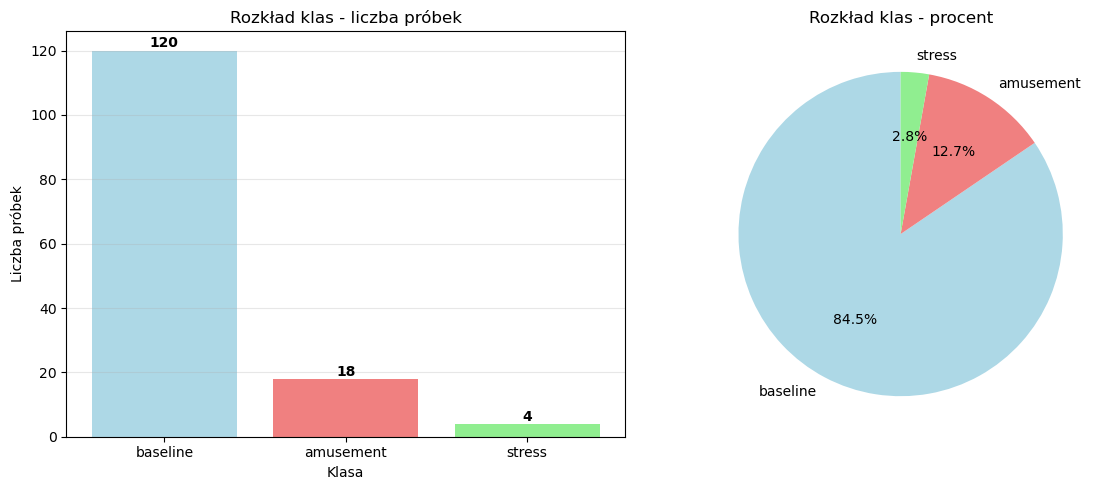


ROZKŁAD KLAS PER UCZESTNIK:

 subject  baseline  amusement  stress  total
     S2        19          0       1     20
     S3        19          0       2     21
     S4        19          6       0     25
     S5        20          6       0     26
     S6        20          0       0     20
     S7        23          6       1     30


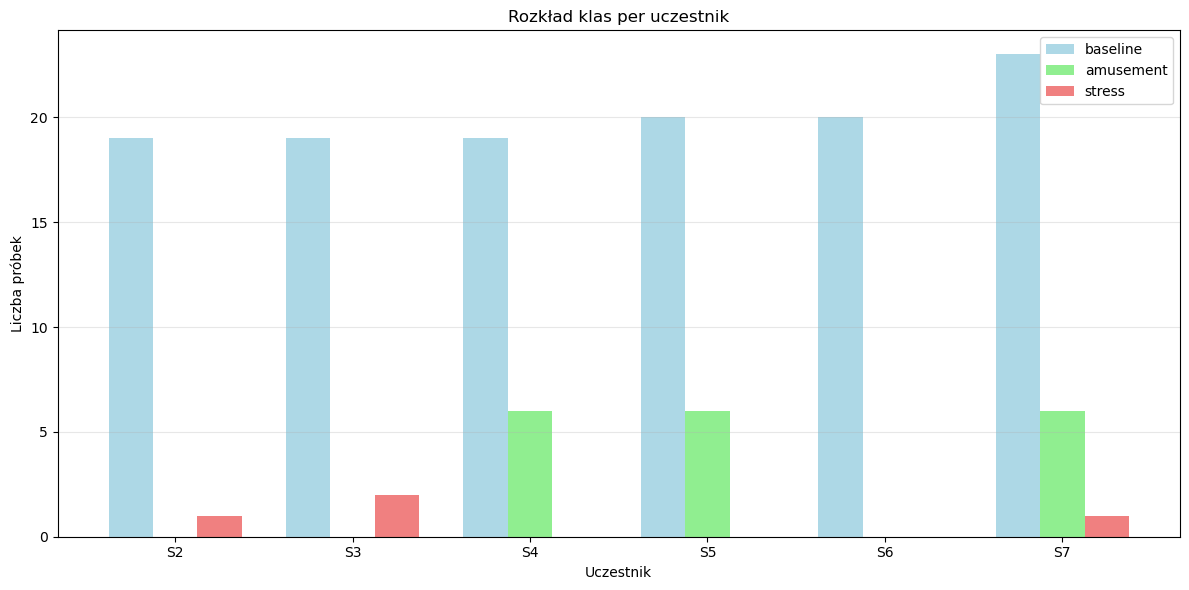


✓ SEKCJA 3-4 ZAKOŃCZONA

💡 WNIOSKI:
   ⚠️ Klasa 'stress' ma tylko 4 próbek - to za mało!
      → Rozważ usunięcie tej klasy lub kombinację z 'amusement'
   ⚠️ Duża nierównowaga między baseline a amusement (6.7x)
      → Wymagane balansowanie przed trenowaniem ML


In [16]:
# ============================================================================
# SEKCJA 3-4: WCZYTYWANIE PRZETWORZONYCH DANYCH I ANALIZA ROZKŁADU KLAS
# ============================================================================

print("=" * 80)
print("SEKCJA 3-4: WCZYTYWANIE DANYCH PO SEGMENTACJI I ANALIZA ROZKŁADU KLAS")
print("=" * 80)

# Wczytujemy przetworzone dane (już po segmentacji)
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed" / "multi_subject_wrist_chest.csv"
PARQUET_PATH = PROJECT_ROOT / "data" / "processed" / "multi_subject_wrist_chest.parquet"

multi_dataset_full = None

# Próbujemy wczytać z parquet (szybsze)
if PARQUET_PATH.exists():
    try:
        import pyarrow
        multi_dataset_full = pd.read_parquet(PARQUET_PATH)
        print(f"\n✓ Wczytano z Parquet: {len(multi_dataset_full)} próbek")
    except ImportError:
        print("⚠ Nie można wczytać Parquet (brak pyarrow) - próbuję CSV...")
        if PROCESSED_DATA_PATH.exists():
            multi_dataset_full = pd.read_csv(PROCESSED_DATA_PATH)
            print(f"✓ Wczytano z CSV: {len(multi_dataset_full)} próbek")
elif PROCESSED_DATA_PATH.exists():
    multi_dataset_full = pd.read_csv(PROCESSED_DATA_PATH)
    print(f"\n✓ Wczytano z CSV: {len(multi_dataset_full)} próbek")
else:
    print(f"\n❌ BŁĄD: Nie znaleziono przetworzonych danych!")
    print(f"   Ścieżki sprawdzone:")
    print(f"     - {PARQUET_PATH}")
    print(f"     - {PROCESSED_DATA_PATH}")
    print(f"\n   💡 Uruchom najpierw notebook '01_complete_analysis.ipynb'")
    print(f"      aby przetworzyć dane i zapisać je do CSV/Parquet")

if multi_dataset_full is not None:
    print(f"\n{'='*80}")
    print("SEKCJA 4: ANALIZA PROBLEMU NIEZBALANSOWANYCH KLAS")
    print(f"{'='*80}")
    
    # Rozkład klas
    class_dist = multi_dataset_full['label'].value_counts()
    
    print(f"\n📊 ROZKŁAD KLAS PO SEGMENTACJI:")
    print("-" * 80)
    for label in ['baseline', 'stress', 'amusement']:
        count = class_dist.get(label, 0)
        pct = (count / len(multi_dataset_full) * 100) if len(multi_dataset_full) > 0 else 0
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    total = len(multi_dataset_full)
    print(f"\n  Total: {total} próbek")
    
    # Analiza nierównowagi
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    if stress_count > 0:
        imbalance_stress = baseline_count / stress_count
        print(f"\n  ⚠️ NIERÓWNOWAGA (baseline vs stress): {imbalance_stress:.1f}x")
    
    if amusement_count > 0:
        imbalance_amusement = baseline_count / amusement_count
        print(f"  ⚠️ NIERÓWNOWAGA (baseline vs amusement): {imbalance_amusement:.1f}x")
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Barplot
    axes[0].bar(class_dist.index, class_dist.values, color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[0].set_xlabel('Klasa')
    axes[0].set_ylabel('Liczba próbek')
    axes[0].set_title('Rozkład klas - liczba próbek')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości na słupkach
    for i, (label, count) in enumerate(class_dist.items()):
        axes[0].text(i, count + 1, str(count), ha='center', fontsize=10, fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', 
               colors=['lightblue', 'lightcoral', 'lightgreen'], startangle=90)
    axes[1].set_title('Rozkład klas - procent')
    
    plt.tight_layout()
    plt.show()
    
    # Rozkład per uczestnik
    if 'subject' in multi_dataset_full.columns:
        print(f"\n{'='*80}")
        print("ROZKŁAD KLAS PER UCZESTNIK:")
        print(f"{'='*80}")
        
        subjects = sorted(multi_dataset_full['subject'].unique())
        subject_distribution = []
        
        for subject in subjects:
            subject_data = multi_dataset_full[multi_dataset_full['subject'] == subject]
            subject_class_dist = subject_data['label'].value_counts()
            subject_distribution.append({
                'subject': subject,
                'baseline': subject_class_dist.get('baseline', 0),
                'amusement': subject_class_dist.get('amusement', 0),
                'stress': subject_class_dist.get('stress', 0),
                'total': len(subject_data)
            })
        
        dist_df = pd.DataFrame(subject_distribution)
        print("\n", dist_df.to_string(index=False))
        
        # Wykres per uczestnik
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(subjects))
        width = 0.25
        
        ax.bar(x - width, dist_df['baseline'], width, label='baseline', color='lightblue')
        ax.bar(x, dist_df['amusement'], width, label='amusement', color='lightgreen')
        ax.bar(x + width, dist_df['stress'], width, label='stress', color='lightcoral')
        
        ax.set_xlabel('Uczestnik')
        ax.set_ylabel('Liczba próbek')
        ax.set_title('Rozkład klas per uczestnik')
        ax.set_xticks(x)
        ax.set_xticklabels(subjects)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n{'='*80}")
    print("✓ SEKCJA 3-4 ZAKOŃCZONA")
    print(f"{'='*80}")
    print("\n💡 WNIOSKI:")
    if stress_count < 10:
        print(f"   ⚠️ Klasa 'stress' ma tylko {stress_count} próbek - to za mało!")
        print(f"      → Rozważ usunięcie tej klasy lub kombinację z 'amusement'")
    if imbalance_amusement > 5:
        print(f"   ⚠️ Duża nierównowaga między baseline a amusement ({imbalance_amusement:.1f}x)")
        print(f"      → Wymagane balansowanie przed trenowaniem ML")


## 3. Segmentacja sygnałów

### 3.1. Cięcie na okna

Typowe okna:
- **5 sekund**
- **10 sekund**
- **30 sekund**

W WESAD najczęściej stosuje się **10 lub 30 sekund**.

### 3.2. Okno = obserwacja

Dla każdego okna wyliczamy:
- średnia
- odchylenie standardowe
- min, max
- sygnał w dziedzinie częstotliwości (FFT)
- cechy kardiologiczne (np. HR z BVP)
- cechy GSR/EDA (np. phasic/tonic)

**Po segmentacji dostajemy:**
- ~kilkaset próbek baseline
- ~kilkadziesiąt amusement
- malutko stress → **tu mamy problem**


## 4. Problem niezbalansowanych klas

### Twoje dane:
- **baseline:** 120 próbek
- **amusement:** 18 próbek
- **stress:** 4 próbki

**To duży problem** – klasyfikator będzie ignorował stress!

### Dlaczego to problem?

1. Model będzie uczył się głównie na baseline (większość danych)
2. Klasa stress jest zbyt mała do nauki wzorców
3. Accuracy będzie zawyżone (model przewiduje zawsze baseline)
4. Model nie nauczy się rozpoznawać stress i amusement


## 5. Jak obejść niezbalansowanie – prawidłowa procedura

### ⚠️ **NAJWAŻNIEJSZE:** Oversampling TYLKO po segmentacji

**❌ BŁĄD:** Nie robimy oversamplingu na surowych sygnałach!

**✅ POPRAWNIE:** Najpierw segmentacja → dopiero potem oversampling.

**Dlaczego?**
- Oversampling duplikowałby sygnały bez okien i bez znaczenia czasowego → nielogiczne
- Po segmentacji mamy już gotowe cechy (features), które możemy balansować

### 5.1. Aglomeracja (opcjonalna)

Możesz scalić klasy stress + amusement → "non-baseline", ale:
- To zmienia cel badania
- Nauczyciele czasem to akceptują, bo stress i amusement mają mało danych
- **Lepiej zostawić 3 klasy i użyć algorytmów balansu**


SEKCJA 7-8: CROSS-SUBJECT VALIDATION I TRENOWANIE MODELI

✓ Przygotowuję dane dla ML...
  Liczba próbek po filtracji (bez stress): 138
  Liczba cech: 15
  Liczba próbek: 138
  Klasy: ['amusement' 'baseline']

  Rozkład klas:
    baseline    :  120 próbek
    amusement   :   18 próbek

CROSS-SUBJECT VALIDATION (Leave-One-Subject-Out)

  Liczba uczestników: 6
  Używamy 5-fold cross-validation
  Uczestnicy: S2, S3, S4, S5, S6, S7

  ✓ SMOTE dostępny - użyjemy do balansowania
  ✓ XGBoost dostępny (objective: binary:logistic)

TRENOWANIE: RandomForest

  Fold 1 - rozkład klas w train:
    baseline    :   97 próbek
    amusement   :   12 próbek
  Fold 1 - po SMOTE:
    baseline    :   97 próbek
    amusement   :   97 próbek

  📊 ŚREDNIE WYNIKI (RandomForest):
     Macro F1-score: 0.692 ± 0.257

  📋 Classification Report (wszystkie foldy):
     Klasa        Precision    Recall       F1-score    
     ------------------------------------------------
     amusement    1.000        0.056        

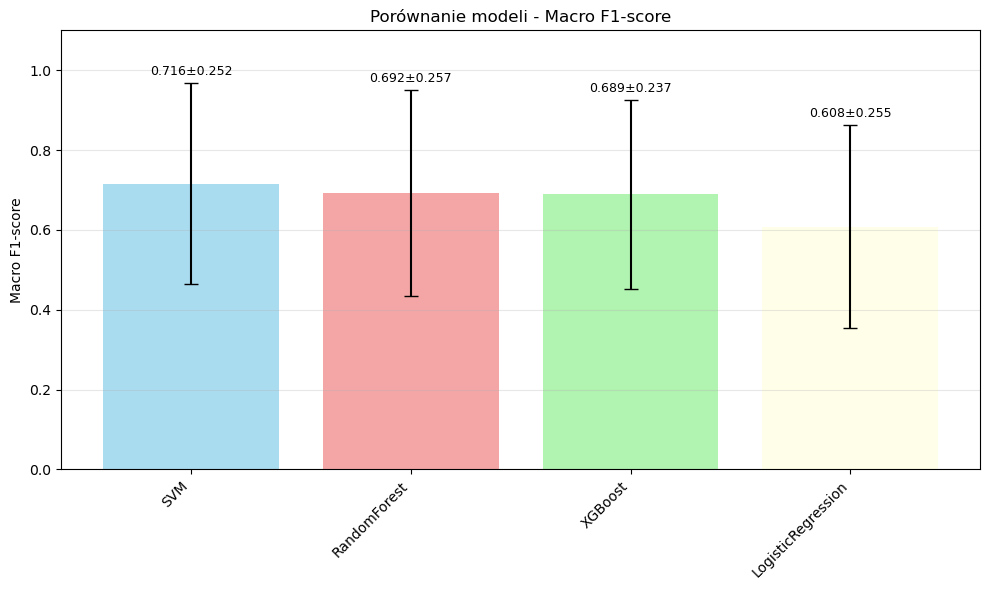


🎯 NAJLEPSZY MODEL: SVM
   Macro F1-score: 0.716

✓ SEKCJA 7-8 ZAKOŃCZONA


In [17]:
# ============================================================================
# SEKCJA 7-8: PODZIAŁ DANYCH I TRENOWANIE MODELI
# ============================================================================

print("=" * 80)
print("SEKCJA 7-8: CROSS-SUBJECT VALIDATION I TRENOWANIE MODELI")
print("=" * 80)

# Sprawdzenie czy mamy dane
if 'multi_dataset_full' not in globals() or multi_dataset_full is None:
    print("\n⚠ Najpierw uruchom sekcję 3-4, aby wczytać dane")
else:
    # Przygotowanie danych
    print(f"\n✓ Przygotowuję dane dla ML...")
    
    # Filtrujemy tylko baseline i amusement (stress ma za mało próbek)
    data_ml = multi_dataset_full[multi_dataset_full['label'].isin(['baseline', 'amusement'])].copy()
    
    print(f"  Liczba próbek po filtracji (bez stress): {len(data_ml)}")
    
    # Feature columns
    feature_columns = [col for col in data_ml.columns 
                      if col not in {"timestamp", "phase", "label", "subject"}]
    
    X_ml = data_ml[feature_columns].fillna(0.0).values
    y_ml = data_ml["label"].values
    groups_ml = data_ml["subject"].values
    
    print(f"  Liczba cech: {len(feature_columns)}")
    print(f"  Liczba próbek: {len(X_ml)}")
    
    # Label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_ml_encoded = label_encoder.fit_transform(y_ml)
    
    print(f"  Klasy: {label_encoder.classes_}")
    
    # Rozkład klas
    class_dist_ml = pd.Series(y_ml).value_counts()
    print(f"\n  Rozkład klas:")
    for label in class_dist_ml.index:
        print(f"    {label:12s}: {class_dist_ml[label]:4d} próbek")
    
    # CROSS-SUBJECT VALIDATION - KLUCZOWE!
    print(f"\n{'='*80}")
    print("CROSS-SUBJECT VALIDATION (Leave-One-Subject-Out)")
    print(f"{'='*80}")
    
    from sklearn.model_selection import GroupKFold
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report, f1_score, confusion_matrix
    import warnings
    warnings.filterwarnings('ignore')
    
    # Liczba uczestników
    unique_subjects = np.unique(groups_ml)
    n_splits = min(5, len(unique_subjects))
    
    print(f"\n  Liczba uczestników: {len(unique_subjects)}")
    print(f"  Używamy {n_splits}-fold cross-validation")
    print(f"  Uczestnicy: {', '.join(sorted(unique_subjects))}")
    
    gkf = GroupKFold(n_splits=n_splits)
    
    # Sprawdzenie czy SMOTE jest dostępny
    try:
        from imblearn.over_sampling import SMOTE
        SMOTE_AVAILABLE = True
        print(f"\n  ✓ SMOTE dostępny - użyjemy do balansowania")
    except ImportError:
        SMOTE_AVAILABLE = False
        print(f"\n  ⚠ SMOTE niedostępny - użyjemy tylko class_weight")
        print(f"     Zainstaluj: pip install imbalanced-learn")
    
    # Modele do przetestowania
    models_to_test = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            random_state=42,
            class_weight='balanced'
        ),
        'SVM': SVC(
            kernel='rbf',
            probability=True,
            random_state=42,
            class_weight='balanced'
        ),
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        )
    }
    
    # Próbujemy dodać XGBoost
    try:
        from xgboost import XGBClassifier
        
        # Sprawdzenie liczby klas
        n_classes = len(label_encoder.classes_)
        if n_classes == 2:
            xgb_objective = 'binary:logistic'
            xgb_eval_metric = 'logloss'
        else:
            xgb_objective = 'multi:softprob'
            xgb_eval_metric = 'mlogloss'
        
        models_to_test['XGBoost'] = XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            objective=xgb_objective,
            eval_metric=xgb_eval_metric,
            scale_pos_weight=class_dist_ml.get('baseline', 1) / class_dist_ml.get('amusement', 1) if n_classes == 2 else None
        )
        print(f"  ✓ XGBoost dostępny (objective: {xgb_objective})")
    except ImportError:
        print(f"  ⚠ XGBoost niedostępny - pomijam")
    
    # Wyniki dla wszystkich modeli
    all_results = {}
    
    # Testowanie każdego modelu
    for model_name, model in models_to_test.items():
        print(f"\n{'='*80}")
        print(f"TRENOWANIE: {model_name}")
        print(f"{'='*80}")
        
        fold_results = []
        all_y_test = []
        all_y_pred = []
        
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_ml, y_ml_encoded, groups_ml), start=1):
            X_train, X_test = X_ml[train_idx], X_ml[test_idx]
            y_train, y_test = y_ml_encoded[train_idx], y_ml_encoded[test_idx]
            
            # Sprawdzenie rozkładu w train (fold 1)
            if fold == 1:
                train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
                print(f"\n  Fold {fold} - rozkład klas w train:")
                for label in train_dist.index:
                    print(f"    {label:12s}: {train_dist[label]:4d} próbek")
            
            # SMOTE tylko na zbiorze treningowym (jeśli dostępny)
            X_train_bal = X_train
            y_train_bal = y_train
            
            if SMOTE_AVAILABLE:
                try:
                    k_neighbors = min(3, len(y_train[y_train == 1]) - 1) if len(y_train[y_train == 1]) > 1 else 1
                    if k_neighbors > 0:
                        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
                        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
                        
                        if fold == 1:
                            train_dist_after = pd.Series(label_encoder.inverse_transform(y_train_bal)).value_counts()
                            print(f"  Fold {fold} - po SMOTE:")
                            for label in train_dist_after.index:
                                print(f"    {label:12s}: {train_dist_after[label]:4d} próbek")
                except Exception as e:
                    if fold == 1:
                        print(f"  ⚠️ SMOTE nie powiódł się dla fold {fold}: {e}")
                    X_train_bal, y_train_bal = X_train, y_train
            
            # Pipeline z scaling
            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("model", model)
            ])
            
            # Trenowanie
            clf.fit(X_train_bal, y_train_bal)
            y_pred = clf.predict(X_test)
            
            # Ewaluacja
            f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
            f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            fold_results.append({
                'fold': fold,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            })
            
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
        
        # Podsumowanie dla modelu
        avg_f1_macro = np.mean([r['f1_macro'] for r in fold_results])
        std_f1_macro = np.std([r['f1_macro'] for r in fold_results])
        
        print(f"\n  📊 ŚREDNIE WYNIKI ({model_name}):")
        print(f"     Macro F1-score: {avg_f1_macro:.3f} ± {std_f1_macro:.3f}")
        
        # Classification report (ze wszystkich foldów)
        print(f"\n  📋 Classification Report (wszystkie foldy):")
        report = classification_report(
            all_y_test, all_y_pred,
            target_names=label_encoder.classes_,
            output_dict=True,
            zero_division=0
        )
        
        print(f"     {'Klasa':<12} {'Precision':<12} {'Recall':<12} {'F1-score':<12}")
        print("     " + "-" * 48)
        for cls in label_encoder.classes_:
            if cls in report:
                prec = report[cls]['precision']
                rec = report[cls]['recall']
                f1 = report[cls]['f1-score']
                print(f"     {cls:<12} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")
        
        all_results[model_name] = {
            'avg_f1_macro': avg_f1_macro,
            'std_f1_macro': std_f1_macro,
            'fold_results': fold_results,
            'y_test': all_y_test,
            'y_pred': all_y_pred,
            'report': report
        }
    
    # Porównanie modeli
    print(f"\n{'='*80}")
    print("PODSUMOWANIE - PORÓWNANIE MODELI")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame({
        'Model': list(all_results.keys()),
        'Macro F1': [all_results[m]['avg_f1_macro'] for m in all_results.keys()],
        'Std': [all_results[m]['std_f1_macro'] for m in all_results.keys()]
    })
    comparison_df = comparison_df.sort_values('Macro F1', ascending=False)
    
    print("\n", comparison_df.to_string(index=False))
    
    # Wykres porównania
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = comparison_df['Model'].values
    f1_scores = comparison_df['Macro F1'].values
    stds = comparison_df['Std'].values
    
    bars = ax.bar(models, f1_scores, yerr=stds, alpha=0.7, capsize=5, 
                  color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'][:len(models)])
    ax.set_ylabel('Macro F1-score')
    ax.set_title('Porównanie modeli - Macro F1-score')
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości na słupkach
    for i, (bar, f1, std) in enumerate(zip(bars, f1_scores, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
               f'{f1:.3f}±{std:.3f}', ha='center', fontsize=9)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Najlepszy model
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\n🎯 NAJLEPSZY MODEL: {best_model_name}")
    print(f"   Macro F1-score: {all_results[best_model_name]['avg_f1_macro']:.3f}")
    
    print(f"\n{'='*80}")
    print("✓ SEKCJA 7-8 ZAKOŃCZONA")
    print(f"{'='*80}")


SEKCJA 9: ANALIZA WYNIKÓW

CONFUSION MATRICES DLA WSZYSTKICH MODELI


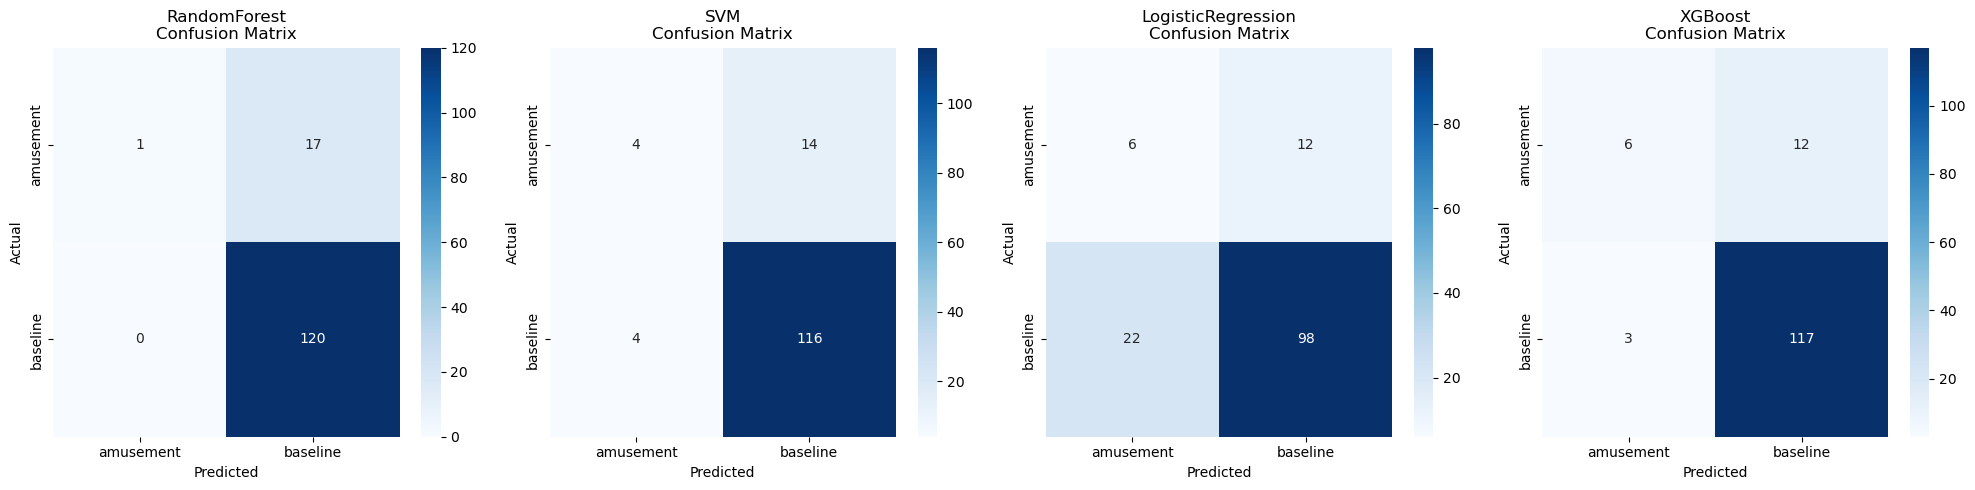


FEATURE IMPORTANCE - RANDOM FOREST

📊 TOP 20 NAJWAŻNIEJSZYCH CECH:
--------------------------------------------------------------------------------
        feature  importance
        hr_mean    0.261842
      temp_mean    0.199964
        eda_std    0.194627
chest_temp_mean    0.096477
       eda_mean    0.076445
 chest_eda_mean    0.074716
         hr_std    0.040306
 chest_ecg_mean    0.026556
chest_resp_mean    0.015571
 chest_resp_std    0.013497
       hr_rmssd    0.000000
       hr_range    0.000000
      eda_range    0.000000
      eda_slope    0.000000
      resp_rate    0.000000


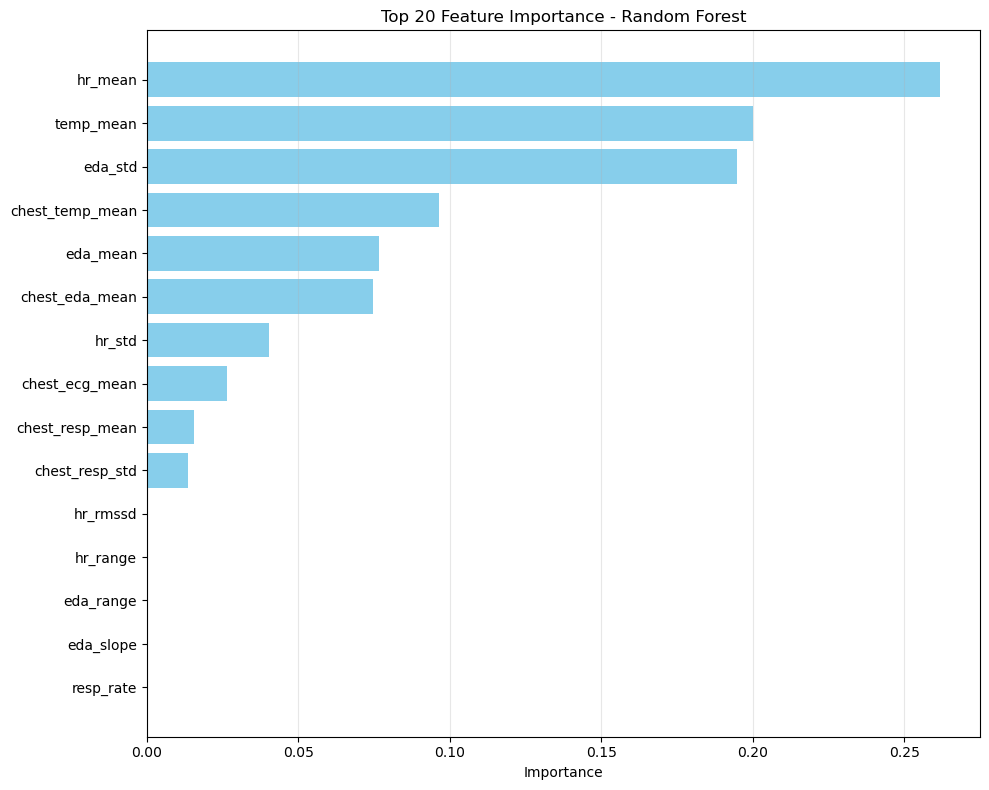


ANALIZA: KTÓRE CZUJNIKI SĄ NAJWAŻNIEJSZE?

  Wrist (nadgarstek): 77.3%
  Chest (klatka): 22.7%


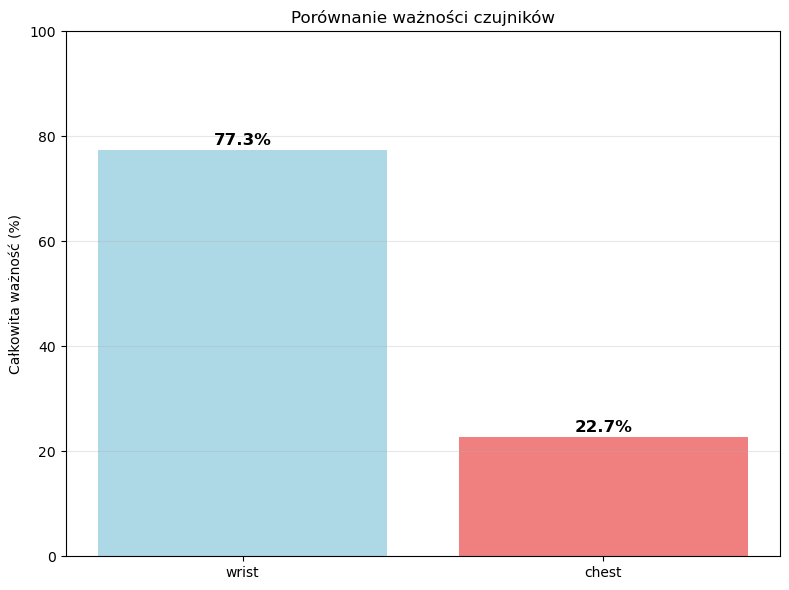


✓ SEKCJA 9 ZAKOŃCZONA

💡 WNIOSKI:
   - Sprawdź confusion matrix - które klasy są mylone?
   - Które cechy najlepiej odróżniają stany?
   - Czy wrist czy chest jest bardziej informatywny?


In [18]:
# ============================================================================
# SEKCJA 9: ANALIZA WYNIKÓW - CONFUSION MATRICES I FEATURE IMPORTANCE
# ============================================================================

print("=" * 80)
print("SEKCJA 9: ANALIZA WYNIKÓW")
print("=" * 80)

# Sprawdzenie czy mamy wyniki
if 'all_results' not in globals() or len(all_results) == 0:
    print("\n⚠ Najpierw uruchom sekcję 7-8, aby wytrenować modele")
else:
    # Confusion Matrices dla wszystkich modeli
    print(f"\n{'='*80}")
    print("CONFUSION MATRICES DLA WSZYSTKICH MODELI")
    print(f"{'='*80}")
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    n_models = len(all_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(all_results.items()):
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Importance (dla RandomForest)
    if 'RandomForest' in all_results:
        print(f"\n{'='*80}")
        print("FEATURE IMPORTANCE - RANDOM FOREST")
        print(f"{'='*80}")
        
        # Musimy wytrenować model ponownie na wszystkich danych (dla feature importance)
        # Ale możemy użyć najlepszego modelu z cross-validation
        
        # Najpierw SMOTE na wszystkich danych treningowych
        if SMOTE_AVAILABLE:
            try:
                smote_all = SMOTE(random_state=42, k_neighbors=min(3, len(y_ml_encoded[y_ml_encoded == 1]) - 1))
                X_all_bal, y_all_bal = smote_all.fit_resample(X_ml, y_ml_encoded)
            except:
                X_all_bal, y_all_bal = X_ml, y_ml_encoded
        else:
            X_all_bal, y_all_bal = X_ml, y_ml_encoded
        
        # Trenowanie na wszystkich danych
        rf_all = Pipeline([
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(
                n_estimators=200,
                max_depth=8,
                random_state=42,
                class_weight='balanced'
            ))
        ])
        rf_all.fit(X_all_bal, y_all_bal)
        
        # Feature importance
        feature_importance = rf_all.named_steps['rf'].feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        # Top 20 features
        top_features = importance_df.head(20)
        
        print(f"\n📊 TOP 20 NAJWAŻNIEJSZYCH CECH:")
        print("-" * 80)
        print(top_features.to_string(index=False))
        
        # Wykres feature importance
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(top_features)), top_features['importance'].values, color='skyblue')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values)
        ax.invert_yaxis()
        ax.set_xlabel('Importance')
        ax.set_title('Top 20 Feature Importance - Random Forest')
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        # Analiza - które czujniki są najważniejsze?
        print(f"\n{'='*80}")
        print("ANALIZA: KTÓRE CZUJNIKI SĄ NAJWAŻNIEJSZE?")
        print(f"{'='*80}")
        
        sensor_importance = {
            'wrist': 0,
            'chest': 0
        }
        
        for _, row in importance_df.iterrows():
            feature = row['feature']
            importance = row['importance']
            if 'chest' in feature.lower():
                sensor_importance['chest'] += importance
            else:
                sensor_importance['wrist'] += importance
        
        total_importance = sum(sensor_importance.values())
        
        print(f"\n  Wrist (nadgarstek): {sensor_importance['wrist']/total_importance*100:.1f}%")
        print(f"  Chest (klatka): {sensor_importance['chest']/total_importance*100:.1f}%")
        
        # Wykres porównania
        fig, ax = plt.subplots(figsize=(8, 6))
        sensors = list(sensor_importance.keys())
        importances = [sensor_importance[s] / total_importance * 100 for s in sensors]
        
        bars = ax.bar(sensors, importances, color=['lightblue', 'lightcoral'])
        ax.set_ylabel('Całkowita ważność (%)')
        ax.set_title('Porównanie ważności czujników')
        ax.set_ylim([0, 100])
        ax.grid(True, alpha=0.3, axis='y')
        
        # Dodaj wartości na słupkach
        for bar, imp in zip(bars, importances):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{imp:.1f}%', ha='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n{'='*80}")
    print("✓ SEKCJA 9 ZAKOŃCZONA")
    print(f"{'='*80}")
    
    print("\n💡 WNIOSKI:")
    print("   - Sprawdź confusion matrix - które klasy są mylone?")
    print("   - Które cechy najlepiej odróżniają stany?")
    print("   - Czy wrist czy chest jest bardziej informatywny?")


### 5.2. Metody balansu

#### 1. **SMOTE (Synthetic Minority Oversampling Technique)**

**Co robi:** Tworzy brakujące próbki na podstawie najbliższych sąsiadów

**Jak działa:**
- Wybiera próbkę z klasy mniejszościowej
- Znajduje k najbliższych sąsiadów (zwykle k=5)
- Tworzy nową syntetyczną próbkę między nimi

**Zastosowanie:** Działa po ekstrakcji cech (po segmentacji!)

**✅ Zalety:**
- Nie duplikuje istniejących próbek
- Tworzy realistyczne syntetyczne dane
- Nie traci danych z klasy większościowej

**⚠️ Uwagi:**
- Wymaga co najmniej k+1 próbek w klasie mniejszościowej
- Może tworzyć próbki w obszarach nakładających się z innymi klasami

---

#### 2. **ADASYN (Adaptive Synthetic Sampling)**

**Co robi:** Podobne do SMOTE, ale skupia się na najmniejszych klasach

**Jak działa:**
- Automatycznie określa, ile próbek syntetycznych utworzyć dla każdej klasy
- Więcej próbek dla klas trudniejszych do klasyfikacji

**✅ Zalety:**
- Lepsze dla bardzo niezbalansowanych danych
- Adaptacyjne - dostosowuje się do trudności klasyfikacji

---

#### 3. **Class Weights (Wagi klas)**

**Co robi:** Mówi modelowi: "klasa stress jest 20x ważniejsza"

**Może być użyte z:**
- SVM
- Logistic Regression
- Random Forest
- XGBoost

**Jak działa:**
- Model "kara" więcej za błędy w klasie mniejszościowej
- Większa waga = większa dokładność dla tej klasy

**✅ Zalety:**
- Nie zmienia danych (wszystkie próbki zostają)
- Proste w implementacji
- Nie wymaga dodatkowych bibliotek

**⚠️ Uwagi:**
- Może nie wystarczyć przy bardzo dużej nierównowadze
- Często używane razem z SMOTE

---

#### 4. **Downsampling baseline**

**Co robi:** Zmniejsza baseline 120 → np. 40

**✅ Zalety:**
- Wszystkie próbki są prawdziwe
- Zrównoważone klasy

**⚠️ Ryzykowne:**
- Tracimy dane z klasy większościowej
- Baseline często jest potrzebny jako punkt odniesienia
- Mniejsza próbka = mniejsza moc statystyczna


## 6. Tworzenie cech (feature engineering)

### Dla EDA (Electrodermal Activity):
- **Średnia** - poziom toniczny (podstawowy)
- **Odchylenie standardowe (SD)** - zmienność
- **Skew** - asymetria rozkładu
- **Tonic level** - podstawowy poziom przewodnictwa
- **Liczba reakcji skórnych** - liczba skoków (phasic responses)

### Dla BVP (Blood Volume Pulse):
- **HR (Heart Rate)** - tętno z BVP
- **HRV (Heart Rate Variability)**
  - **RMSSD** - Root Mean Square of Successive Differences
  - **SDNN** - Standard Deviation of NN intervals
- **Peak intervals** - odstępy między szczytami

### Dla ACC (Accelerometer):
- **RMS (Root Mean Square)** - miara ruchu/aktywności
- **Energia sygnału** - całkowita energia w dziedzinie częstotliwości
- **Magnitude** - √(acc_x² + acc_y² + acc_z²)

### Dla TEMP (Temperature):
- **Średnia** - podstawowa temperatura
- **Zmiana temperatury** - gradient (slope)

### Dla CHEST (czujniki klatki piersiowej):
- **ECG**: tętno, HRV, odstępy R-R
- **Respiration**: tempo oddychania, głębokość
- **EMG**: aktywność mięśniowa


## 7. Podział danych i ewaluacja

### 7.1. Podział na train/test w sposób właściwy

#### ⚠️ **NAJWAŻNIEJSZE:** NIE wolno rozdzielać w losowy sposób wszystkich okien!

**❌ BŁĄD:** Losowy podział wszystkich próbek na train/test

**✅ POPRAWNIE:** Cross-subject validation (Leave-One-Subject-Out)

**Dlaczego?**
- WESAD = badanie personalne, więc cross-subject generalization jest kluczowa
- Musimy sprawdzić, czy model działa dla nowych uczestników
- Przykład:
  - **Train:** uczestnicy S2, S3, S4, S5, S6
  - **Test:** uczestnik S7 (całkowicie nowy)

**Implementacja:**
- Używamy `GroupKFold` z sklearn
- Grupujemy po uczestniku (`subject`)
- Każdy fold = jeden uczestnik w test, pozostali w train

### 7.2. Metryki

#### ⚠️ **Przy niezbalansowaniu: Accuracy jest bez sensu!**

**❌ BŁĄD:** Użycie tylko accuracy

**Dlaczego?**
- Jeśli baseline = 120 próbek, a stress = 4 próbki
- Model przewiduje zawsze baseline → accuracy = 95%
- Ale model w ogóle nie rozpoznaje stress!

**✅ POPRAWNIE:** Używamy metryk, które biorą pod uwagę wszystkie klasy:

1. **Macro F1-score**
   - Średnia F1-score dla wszystkich klas
   - Każda klasa ma równą wagę
   - **Najlepsza metryka dla niezbalansowanych danych!**

2. **Recall każdej klasy**
   - Jak wiele próbek z każdej klasy zostało poprawnie rozpoznanych
   - Ważne: sprawdzić recall dla stress!

3. **Precision każdej klasy**
   - Jak wiele przewidywań danej klasy było poprawnych

4. **Confusion Matrix**
   - Wizualizacja błędów klasyfikacji
   - Pokazuje, które klasy są mylone ze sobą


## 8. Trenowanie modeli

### Modele do przetestowania:

1. **SVM (Support Vector Machine)**
   - Linear kernel
   - RBF kernel
   - Z `class_weight='balanced'`

2. **Random Forest**
   - Z `class_weight='balanced'`
   - Z SMOTE przed trenowaniem

3. **XGBoost**
   - Z wagami klas (scale_pos_weight)
   - Z SMOTE przed trenowaniem
   - **Uwaga:** Dla 2 klas użyj `objective='binary:logistic'`, dla 3 klas `objective='multi:softprob'`

4. **Logistic Regression**
   - Z `class_weight='balanced'`

5. **KNN (K-Nearest Neighbors)**
   - Po SMOTE

### Strategia:
1. Najpierw trenuj bez balansowania (baseline)
2. Potem trenuj z `class_weight='balanced'`
3. Na koniec trenuj z SMOTE + `class_weight='balanced'`
4. Porównaj wyniki wszystkich podejść


## 9. Analiza wyników

### Pytania do odpowiedzi:

1. **Jaka cecha najlepiej odróżnia stres?**
   - SHAP values (ważność cech)
   - Feature importance z Random Forest/XGBoost
   - Analiza korelacji między cechami a klasami

2. **Które modele radzą sobie najlepiej?**
   - Porównanie Macro F1-score
   - Porównanie Recall per klasa
   - Porównanie Confusion Matrix

3. **Czy SMOTE poprawił diagnostykę klasy stress?**
   - Porównanie recall dla stress przed i po SMOTE
   - Porównanie confusion matrix

4. **Czy wrist czy chest ma większy wpływ?**
   - Porównanie cech z wrist vs chest w feature importance
   - Analiza korelacji cross-sensor

### Wizualizacje:
- Confusion Matrix dla każdego modelu
- Feature importance plots (SHAP, Random Forest)
- ROC curves (dla klas binarnych)
- Boxplots cech per klasa
- Korelacje między cechami a klasami


## 10. Interpretacja i raport

### W raporcie musi znaleźć się:

### 10.1. Problem:

**"Dane są silnie niezbalansowane, szczególnie klasa stress (4 próbki)."**

- Opis rozkładu klas przed i po segmentacji
- Wizualizacja nierównowagi (barplot, pie chart)
- Wyjaśnienie, dlaczego to problem dla ML

### 10.2. Rozwiązanie:

#### Opis zastosowanych metod:

1. **Segmentacja → oversampling (SMOTE/ADASYN)**
   - Wyjaśnienie, dlaczego SMOTE po segmentacji, a nie przed
   - Opis procesu SMOTE
   - Rozkład klas po SMOTE

2. **Class weights**
   - Wyjaśnienie, jak działa
   - Jakie wagi zastosowano
   - W których modelach użyto

3. **Ewaluacja macro-F1, a nie accuracy**
   - Wyjaśnienie, dlaczego accuracy jest niewystarczające
   - Dlaczego macro-F1 jest lepsze dla niezbalansowanych danych

### 10.3. Wnioski:

#### Muszą zawierać:

1. **Stress trudny do wykrycia**
   - Recall dla stress (przed i po balansowaniu)
   - Dlaczego stress jest trudny (mało danych, podobny do baseline?)

2. **Wrist/chest mogą mieć różną jakość sygnałów**
   - Które czujniki są bardziej informatywne
   - Korelacje między wrist a chest
   - Feature importance per sensor

3. **Model potrzebuje balansu, inaczej ignoruje małe klasy**
   - Porównanie wyników przed i po balansowaniu
   - Czy SMOTE poprawił wyniki?
   - Które podejście działa najlepiej?

### 10.4. Struktura raportu:

```
1. Wstęp
   - Cel projektu
   - Hipoteza badawcza
   
2. Metodologia
   - Opis danych
   - Preprocessing (synchronizacja, segmentacja)
   - Feature engineering
   - Metody balansowania
   - Modele ML
   
3. Wyniki
   - Rozkład klas (przed i po balansowaniu)
   - Wyniki modeli (Macro F1, Recall, Precision)
   - Feature importance
   - Confusion matrices
   
4. Dyskusja
   - Interpretacja wyników
   - Porównanie metod balansowania
   - Ograniczenia badania
   
5. Wnioski
   - Podsumowanie najważniejszych ustaleń
   - Rekomendacje dla przyszłych badań
```

### 10.5. Checklist przed oddaniem:

- [ ] Opis problemu niezbalansowania klas
- [ ] Wyjaśnienie, dlaczego SMOTE po segmentacji
- [ ] Porównanie wyników przed i po balansowaniu
- [ ] Użycie macro-F1 zamiast tylko accuracy
- [ ] Cross-subject validation (nie losowy podział!)
- [ ] Feature importance analysis
- [ ] Confusion matrices dla wszystkich modeli
- [ ] Interpretacja wyników dla każdej klasy
- [ ] Dyskusja ograniczeń (mała próbka stress)


## Przykład implementacji - kluczowe elementy

Poniżej przykładowy kod dla najważniejszych części analizy.


In [19]:
# ============================================================================
# PRZYKŁAD: SMOTE + Cross-Subject Validation
# ============================================================================

from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

# ZAŁOŻENIA:
# - X_segmented: features po segmentacji (shape: n_samples, n_features)
# - y_segmented: labels po segmentacji (shape: n_samples,)
# - groups_segmented: subject IDs (shape: n_samples,)

print("=" * 80)
print("PRZYKŁAD: SMOTE + Cross-Subject Validation")
print("=" * 80)

# 1. SPRAWDZENIE ROZKŁADU KLAS
print("\n1. ROZKŁAD KLAS PRZED BALANSOWANIEM:")
class_dist_before = pd.Series(y_segmented).value_counts()
for label in class_dist_before.index:
    print(f"   {label:12s}: {class_dist_before[label]:4d} próbek")
imbalance_before = class_dist_before.max() / class_dist_before.min()
print(f"   Nierównowaga: {imbalance_before:.2f}x")

# 2. CROSS-SUBJECT VALIDATION
# Grupujemy po uczestniku - każdy fold = jeden uczestnik w test
gkf = GroupKFold(n_splits=5)  # np. dla 5 uczestników

fold_results = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_segmented, y_segmented, groups_segmented), start=1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold}")
    print(f"{'='*80}")
    
    X_train, X_test = X_segmented[train_idx], X_segmented[test_idx]
    y_train, y_test = y_segmented[train_idx], y_segmented[test_idx]
    groups_train = groups_segmented[train_idx]
    
    # 3. SMOTE - TYLKO NA ZBIORZE TRENINGOWYM!
    print(f"\n   Przed SMOTE:")
    train_dist_before = pd.Series(y_train).value_counts()
    for label in train_dist_before.index:
        print(f"     {label:12s}: {train_dist_before[label]:4d} próbek")
    
    # SMOTE wymaga co najmniej k+1 próbek w każdej klasie (domyślnie k=5)
    try:
        smote = SMOTE(random_state=42, k_neighbors=min(3, len(y_train[y_train == 1])-1) if len(y_train[y_train == 1]) > 1 else 1)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        print(f"\n   Po SMOTE:")
        train_dist_after = pd.Series(y_train_smote).value_counts()
        for label in train_dist_after.index:
            print(f"     {label:12s}: {train_dist_after[label]:4d} próbek")
    except Exception as e:
        print(f"   ⚠️ SMOTE nie powiódł się: {e}")
        print(f"   → Używam oryginalnych danych")
        X_train_smote, y_train_smote = X_train, y_train
    
    # 4. TRENOWANIE MODELU Z CLASS WEIGHTS
    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        class_weight='balanced'  # Automatyczna kompensacja nierównowagi
    )
    
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)
    
    # 5. EWALUACJA
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n   Wyniki fold {fold}:")
    print(f"     Macro F1-score: {f1_macro:.3f}")
    print(f"     Weighted F1-score: {f1_weighted:.3f}")
    
    # Classification report per klasa
    print(f"\n   Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    for label in sorted(set(y_test)):
        if str(label) in report:
            prec = report[str(label)]['precision']
            rec = report[str(label)]['recall']
            f1 = report[str(label)]['f1-score']
            print(f"     {label:12s}: precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")
    
    fold_results.append({
        'fold': fold,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'y_test': y_test,
        'y_pred': y_pred
    })

# 6. PODSUMOWANIE
print(f"\n{'='*80}")
print("PODSUMOWANIE WSZYSTKICH FOLDÓW:")
print(f"{'='*80}")

avg_f1_macro = np.mean([r['f1_macro'] for r in fold_results])
std_f1_macro = np.std([r['f1_macro'] for r in fold_results])
avg_f1_weighted = np.mean([r['f1_weighted'] for r in fold_results])

print(f"\n   Średni Macro F1-score: {avg_f1_macro:.3f} ± {std_f1_macro:.3f}")
print(f"   Średni Weighted F1-score: {avg_f1_weighted:.3f}")

print(f"\n{'='*80}")
print("✓ PRZYKŁAD ZAKOŃCZONY")
print(f"{'='*80}")
print("\n💡 PAMIĘTAJ:")
print("   - SMOTE tylko na zbiorze treningowym (nie na test!)")
print("   - Cross-subject validation (grupowanie po uczestniku)")
print("   - Używaj Macro F1-score zamiast accuracy")
print("   - Class weights + SMOTE = najlepsza kombinacja")


PRZYKŁAD: SMOTE + Cross-Subject Validation

1. ROZKŁAD KLAS PRZED BALANSOWANIEM:


NameError: name 'y_segmented' is not defined

---

## Podsumowanie - najważniejsze punkty

### ⚠️ **KLUCZOWE ZASADY:**

1. **SMOTE TYLKO PO SEGMENTACJI**
   - ❌ Nie na surowych sygnałach
   - ✅ Najpierw segmentacja, potem SMOTE

2. **CROSS-SUBJECT VALIDATION**
   - ❌ Nie losowy podział próbek
   - ✅ Grupowanie po uczestniku (GroupKFold)

3. **MACRO F1-SCORE, NIE ACCURACY**
   - ❌ Accuracy jest mylące przy niezbalansowaniu
   - ✅ Macro F1-score bierze pod uwagę wszystkie klasy

4. **SMOTE TYLKO NA TRAIN, NIE NA TEST**
   - ✅ Balansowanie tylko na zbiorze treningowym
   - ❌ Nigdy nie balansuj zbioru testowego

5. **COMBINE METHODS**
   - ✅ SMOTE + Class Weights = najlepsza kombinacja
   - ✅ Porównaj różne metody balansowania

---

**Powodzenia w analizie! 🚀**
